<a href="https://colab.research.google.com/github/JCaballerot/Deep_learning_program/blob/main/Deep_learning_program/Modulo_III/Lab_Clasificaci%C3%B3n_de_Texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<h1 align="center"><font size="5">CLASIFICACION DE TEXTO USANDO RNN</font></h1>

Este laboratorio de clasificación de texto entrena una red neuronal recurrente en el gran conjunto de datos [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) para el análisis de sentimientos.


## Configuración

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras as keras


tfds.disable_progress_bar()

Importe `matplotlib` y cree una función auxiliar para trazar gráficos:



In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Configurar entrada

El conjunto de datos de reseñas de películas grandes de IMDB es un conjunto de datos de *clasificación binaria*: todos los reviews tienen un sentimiento *positivo* o *negativo*.

Descargue el conjunto de datos usando [TFDS](https://www.tensorflow.org/datasets). Consulte [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/) para obtener detalles sobre cómo cargar este tipo de datos manualmente.



In [ ]:
dataset, info = tfds.load('imdb_reviews', 
                          with_info = True,
                          as_supervised = True)

train_dataset, test_dataset = dataset['train'], dataset['test']


Inicialmente, esto devuelve un conjunto de datos de (texto, pares de etiquetas):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
df = tfds.as_dataframe(train_dataset, tfds.builder('imdb_reviews').info)
df.shape

(25000, 2)

In [ ]:
df.head(5)


A continuación, reordenamos los datos para el train y creamos batch de estos pares `(text, label)`:



In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

## Precarga

La captación previa se superpone al procesamiento previo y la ejecución del modelo de un paso de formación. Mientras el modelo ejecuta el paso de entrenamiento s , la canalización de entrada lee los datos del paso s+1 . Al hacerlo, se reduce el tiempo de paso al máximo (en lugar de la suma) del entrenamiento y el tiempo que se tarda en extraer los datos.

<>

La API `tf.data` proporciona la transformación `tf.data.Dataset.prefetch`. Se puede utilizar para desacoplar el momento en que se producen los datos del momento en que se consumen los datos. En particular, la transformación utiliza un subproceso en segundo plano y un búfer interno para obtener elementos del conjunto de datos de entrada antes de que se soliciten. El número de elementos para captar previamente debe ser igual (o posiblemente mayor) al número de lotes consumidos por un solo paso de entrenamiento. Puede ajustar manualmente este valor o establecerlo en `tf.data.AUTOTUNE`, lo que solicitará al tiempo de ejecución de tf.data que ajuste el valor dinámicamente durante el tiempo de ejecución.


In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'About two hundred members of a Cleveland, Ohio USA film society, named Cinematheque, gathered on August 19, 2000 to view a pristine Cinemascope print of Michelangelo Antonioni\'s 1970 film, "Zabriskie Point." Cinematheque Director John Ewing, who does a superlative job of obtaining the finest prints for his series, shared with the audience beforehand that this print was specially flown over from Italy for this one showing only.<br /><br />The audience was held spellbound as the film unfolded its artisty on the huge panoramic screen. Watching this superb print, shown the way Antonioni intended, made one aware that this is indeed a modern art work. It was all the more fitting that the series is housed in the Cleveland Insititue of Art in University Circle. <br /><br />Antonioni\'s compositions are created for the Cinemascope landscape. His beautiful balancing of images, striking use of colors, sweeping choreographic movements, all are the work of a genuine artist, using the sc

## Crea el codificador de texto

El texto sin formato cargado por `tfds` debe procesarse antes de que pueda usarse en un modelo. La forma más sencilla de procesar texto para el entrenamiento es utilizar la capa `experimental.preprocessing.TextVectorization`. Esta capa tiene muchas capacidades, pero en este laboratorio nos enfocaremos en el uso principal.

Cree la capa y pase el texto del conjunto de datos al método `.adapt` la capa:

In [ ]:
VOCAB_SIZE = 1000

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens = VOCAB_SIZE)

encoder.adapt(train_dataset.map(lambda text, label: text))


El método `.adapt` establece el vocabulario de la capa. Aquí están los primeros 20 tokens. Después del padding y los tokens desconocidos, se ordenan por frecuencia:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')


Una vez que se establece el vocabulario, la capa puede codificar texto en índices. Los tensores de los índices se rellenan con 0 en la secuencia más larga del lote (a menos que establezca un `output_sequence_length` fijo):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 43, 105,   1, ...,   0,   0,   0],
       [  2,   1,  12, ...,   0,   0,   0],
       [ 10,  63, 453, ...,   0,   0,   0]])


Con la configuración predeterminada, el proceso no es completamente reversible. Hay tres razones principales para ello:

1. El valor predeterminado para `preprocessing.TextVectorization`  `standardize` es `"lower_and_strip_punctuation"`.

2. El tamaño limitado del vocabulario y la falta de respaldo basado en caracteres dan como resultado algunos tokens desconocidos.


In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'About two hundred members of a Cleveland, Ohio USA film society, named Cinematheque, gathered on August 19, 2000 to view a pristine Cinemascope print of Michelangelo Antonioni\'s 1970 film, "Zabriskie Point." Cinematheque Director John Ewing, who does a superlative job of obtaining the finest prints for his series, shared with the audience beforehand that this print was specially flown over from Italy for this one showing only.<br /><br />The audience was held spellbound as the film unfolded its artisty on the huge panoramic screen. Watching this superb print, shown the way Antonioni intended, made one aware that this is indeed a modern art work. It was all the more fitting that the series is housed in the Cleveland Insititue of Art in University Circle. <br /><br />Antonioni\'s compositions are created for the Cinemascope landscape. His beautiful balancing of images, striking use of colors, sweeping choreographic movements, all are the work of a genuine artist, using the 

## Desarrollar el modelo

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Arriba hay un diagrama del modelo.

1. Este modelo se puede construir como `tf.keras.Sequential`.

2. La primera capa es el `encoder`, que convierte el texto en una secuencia de índices de tokens.

3. Después del encoder hay una capa de embedding. Una capa de embedding almacena un vector por palabra. Cuando se llama, convierte las secuencias de índices de palabras en secuencias de vectores. Estos vectores se pueden entrenar. Después del entrenamiento (con suficientes datos), las palabras con significados similares a menudo tienen vectores similares.
Este index-lookup es mucho más eficiente que la operación equivalente de pasar un vector one-hot encoded a través de una capa `tf.keras.layers.Dense`.


4. Una red neuronal recurrente (RNN) procesa la entrada de secuencia iterando a través de los elementos. Los RNN pasan las salidas de un timestep a su entrada en el siguiente timestep.
`tf.keras.layers.Bidirectional` también se puede utilizar con una capa RNN. Esto propaga la entrada hacia adelante y hacia atrás a través de la capa RNN y luego concatena la salida final.
  *   La principal ventaja de un RNN bidireccional es que la señal desde el 
  principio de la entrada no necesita procesarse hasta el final en cada timestep para afectar la salida.
  *   La principal desventaja de un RNN bidireccional es que no puede transmitir predicciones de manera eficiente a medida que se agregan palabras al final.

5. Una vez que el RNN ha convertido la secuencia en un solo vector, las dos `layers.Dense` realizan un procesamiento final y convierten esta representación vectorial en un solo logit como resultado de la clasificación.



El código para implementar esto es el siguiente:

In [ ]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Number of devices: 1


In [ ]:
# model Building

with strategy.scope():
  model = keras.models.Sequential()
  #masking maneja las longitudes de secuencia variable
  model.add(encoder)
  model.add(keras.layers.Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero = True))
  model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dense(1))
  

In [ ]:
  model = keras.models.Sequential()
  #masking maneja las longitudes de secuencia variable
  model.add(encoder)
  model.add(keras.layers.Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero = True))
  model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_________________________________________________________________


Tenga en cuenta que aquí se utiliza el modelo secuencial de Keras, ya que todas las capas del modelo solo tienen una entrada única y producen una salida única. En caso de que desee utilizar la capa RNN con estado, es posible que desee crear su modelo con la API funcional de Keras o la subclasificación del modelo para poder recuperar y reutilizar los estados de la capa RNN. Consulte la [Guía de Keras RNN](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) para obtener más detalles.



La capa de embedding utiliza [masking](https://www.tensorflow.org/guide/keras/masking_and_padding) para manejar las diferentes longitudes de secuencia. Todas las capas después del `Embedding` soportan masking:


In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Compile el modelo de Keras para configurar el proceso de entrenamiento:



In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

## Entrenar el modelo

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

history = model.fit(train_dataset, epochs = 10,
                    validation_data = test_dataset,
                    validation_steps = 30,
                    callbacks = [early_stopping])

Epoch 1/10
391/391 [==============================] - 41s 81ms/step - loss: 0.6542 - accuracy: 0.5536 - val_loss: 0.4803 - val_accuracy: 0.7531
Epoch 2/10
391/391 [==============================] - 30s 76ms/step - loss: 0.4090 - accuracy: 0.8105 - val_loss: 0.3752 - val_accuracy: 0.8339
Epoch 3/10
391/391 [==============================] - 30s 76ms/step - loss: 0.3479 - accuracy: 0.8483 - val_loss: 0.3435 - val_accuracy: 0.8495
Epoch 4/10
391/391 [==============================] - 30s 76ms/step - loss: 0.3293 - accuracy: 0.8587 - val_loss: 0.3385 - val_accuracy: 0.8484
Epoch 5/10
391/391 [==============================] - 30s 76ms/step - loss: 0.3123 - accuracy: 0.8661 - val_loss: 0.3261 - val_accuracy: 0.8620
Epoch 6/10
391/391 [==============================] - 30s 75ms/step - loss: 0.3080 - accuracy: 0.8691 - val_loss: 0.3289 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 30s 75ms/step - loss: 0.3023 - accuracy: 0.8694 - val_loss: 0.3257 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 13s 33ms/step - loss: 0.3162 - accuracy: 0.8570
Test Loss: 0.31624191999435425
Test Accuracy: 0.8569999933242798


(0.0, 0.6720019832253457)

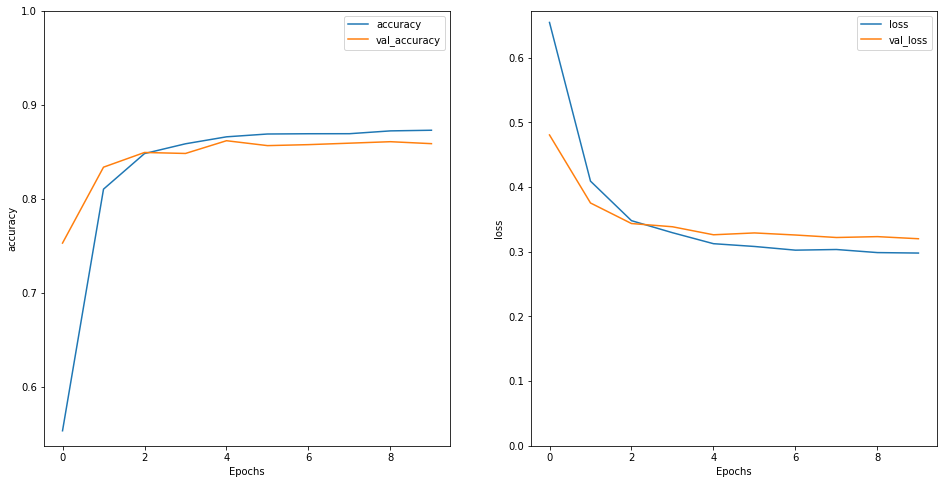

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


Ejecute una predicción en una nueva sentencia:

Si la predicción es > = 0.0, es positiva, de lo contrario es negativa.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

predictions = model.predict(np.array([sample_text]))

print(predictions)

[[-2.5754933]]


## Stacking de dos o mas capas LSTM

Las capas recurrentes de Keras tienen dos modos disponibles que están controlados por el argumento `return_sequences`:

*   Si es `False`, devuelve solo la última salida para cada secuencia de entrada (un tensor de forma 2D (`batch_size`, `output_features`)). Este es el predeterminado, utilizado en el modelo anterior.

*   Si es True se devuelven las secuencias completas de salidas sucesivas para cada timestep (un tensor de forma 3D (`batch_size`, `timesteps`, `output_features`) ).

Así es como se ve el flujo de información con `return_sequences=True` :

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)


Lo interesante de usar un RNN con `return_sequences=True` es que la salida todavía tiene 3 ejes, como la entrada, por lo que se puede pasar a otra capa RNN, así:

In [ ]:

with strategy.scope():
  model = keras.models.Sequential()
  model.add(encoder)
  model.add(keras.layers.Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero = True))
  model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)))
  model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(1, activation='tanh'))


In [ ]:
  model = keras.models.Sequential()
  model.add(encoder)
  model.add(keras.layers.Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero = True))
  model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)))
  model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(1, activation='tanh'))

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs = 10,
                    validation_data = test_dataset,
                    validation_steps = 30,
                    callbacks = [early_stopping])

Epoch 1/10
391/391 [==============================] - 70s 148ms/step - loss: 0.6356 - accuracy: 0.5921 - val_loss: 0.5136 - val_accuracy: 0.7776
Epoch 2/10
391/391 [==============================] - 54s 138ms/step - loss: 0.4809 - accuracy: 0.8206 - val_loss: 0.4693 - val_accuracy: 0.8417
Epoch 3/10
391/391 [==============================] - 54s 138ms/step - loss: 0.4632 - accuracy: 0.8417 - val_loss: 0.4667 - val_accuracy: 0.8302
Epoch 4/10
391/391 [==============================] - 54s 138ms/step - loss: 0.4521 - accuracy: 0.8535 - val_loss: 0.4580 - val_accuracy: 0.8464
Epoch 5/10
391/391 [==============================] - 54s 137ms/step - loss: 0.4431 - accuracy: 0.8632 - val_loss: 0.4594 - val_accuracy: 0.8365
Epoch 6/10
391/391 [==============================] - 54s 137ms/step - loss: 0.4419 - accuracy: 0.8638 - val_loss: 0.4523 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 54s 137ms/step - loss: 0.4370 - accuracy: 0.8709 - val_loss: 0.4612 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
# predict on a sample text.
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')

predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Si está interesado en profundizar en RNN puede consultar las [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

Si está interesado en crear RNN personalizados, consulte [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).




### Gracias por completar este laboratorio!